# Object Detection Using Deep learning
---

Object detection is a task in computer vision that involves identifying the presence, location, and type of one or more objects in a given photograph. 
It is a challenging problem that involves building upon methods for object recognition (_e.g._ where are they), object localization (_e.g._ what are their extent), and object classification (_e.g._ what are they).

In recent years, deep learning techniques are achieving state-of-the-art results for object detection, such as on standard benchmark datasets and in computer vision competitions. Notable is the “You Only Look Once”, or YOLO, family of Convolutional Neural Networks that achieve near state-of-the-art results with a single end-to-end model that can perform object detection in real-time. 

In this lab, we will first focus on region-based convolutional neural networks. Then, based on the pre-trained YOLO model “<a href="https://github.com/experiencor/keras-yolo3">keras-yolo3: Training and Detecting Objects with YOLO3</a>” developed by Huynh Ngoc Anh, we will develop a YOLO3 model for object detection on new photographs.

## Requirements

In [1]:
!pip install opencv-python

In [33]:
import struct
import pandas as pd 
import random as rd
import time
import matplotlib.pyplot as plt
from matplotlib import patches

import numpy as np 
from numpy import expand_dims

In [34]:
import h5py  # Output network weights in HDF5 format during checkpointing
import cv2

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [35]:
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array

---
# PART I: Region-Based Convolutional Neural Networks 

---
## Problem Statement

For this lab, we will work on a health-related dataset: our goal is to solve a blood cell detection problem. Specifically, our task is to detect all red blood cells (RBCs), white blood cells (WBCs), and platelets in images taken via microscopic image readings. Below is an example of what our final predictions should look like:

<img src="myBCCD/example.png" width="400" />

We chose this data set because the density of RBCs, WBCs and platelets in our blood stream provides a lot of information about our immune system and hemoglobin. This can help us identify whether a person is healthy or not, and if an abnormality is found in their blood, steps can be taken quickly to diagnose it.

Manually reviewing such samples under a microscope is a tedious process. This is where deep learning models play a key role. They can classify and detect blood cells from microscopic images with impressive accuracy.

---

The full blood cell detection dataset for this lab can be downloaded from [github.com/Shenggan/BCCD_Dataset](https://github.com/Shenggan/BCCD_Dataset). 

---
## Data Exploration

From the whole dataset, I created different files that you can find on moodle. First, I created the division between training set and test set, by randomly choosing images from the whole dataset as training data. In particular:
1. `train_images`: Images we will use to train the model,
2. `test_images`: Images that will be used to make predictions using the trained model,
3. `train.csv`: Contains the name, class and coordinates of the bounding box for each image. There can be multiple rows for an image because a single image can contain more than one object.

Data exploration helps us not only to discover hidden patterns, but also to get a valuable global view of what we are working on. Take a look at our data!

---
### train.csv

First, let's read the `train.csv` file (if you feel like “wasting" time or experimenting, you can create your own $\texttt{.csv}$ file from the original data set).

In [4]:
train = pd.read_csv("myBCCD/train.csv")
train.head(25)

,image_name,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00301.jpg,RBC,278,366,196,291
1,BloodImage_00301.jpg,RBC,359,447,239,334
2,BloodImage_00301.jpg,RBC,523,611,110,205
3,BloodImage_00301.jpg,RBC,447,568,198,309
4,BloodImage_00301.jpg,RBC,183,304,95,206
5,BloodImage_00301.jpg,RBC,164,268,201,307
6,BloodImage_00301.jpg,RBC,191,295,1,105
7,BloodImage_00301.jpg,RBC,90,194,171,277
8,BloodImage_00301.jpg,RBC,496,600,304,410
9,BloodImage_00301.jpg,RBC,271,375,338,444


There are 6 columns in the train file.

##### <span style="color:purple">**Question:** What do they represent?</span>
1. `image_name`: <span style="color:purple">$\boldsymbol\ldots$</span>
2. `cell_type`: <span style="color:purple">$\boldsymbol\ldots$</span>
3. `xmin`: <span style="color:purple">$\boldsymbol\ldots$</span>
4. `xmax`: <span style="color:purple">$\boldsymbol\ldots$</span>
5. `ymin`: <span style="color:purple">$\boldsymbol\ldots$</span>
6. `ymax`: <span style="color:purple">$\boldsymbol\ldots$</span>

---
### Image

##### <span style="color:purple">**Todo:** Display an image of the training dataset</span>

In [116]:
# Display an image of the training dataset (To be completed)

This is what a blood cell image looks like. Here, the blue part represents the WBCs, and the slightly red parts represent the RBCs. 


##### <span style="color:purple">**Question:** How many images, and different type of classes, are there in our training set?</span>

In [117]:
# Number of unique training images (To be completed)

In [118]:
# Number of classes (To be completed)

So, we have <span style="color:purple">$\boldsymbol\ldots$</span> training images and <span style="color:purple">$\boldsymbol\ldots$</span> different classes of cells, _i.e._ <span style="color:purple">$\boldsymbol\ldots$</span>, <span style="color:purple">$\boldsymbol\ldots$</span> , <span style="color:purple">$\boldsymbol\ldots$</span> 

---
### Image with Detected Objects

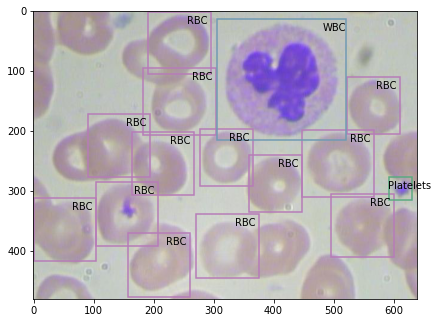

In [120]:
IMG = "BloodImage_00301.jpg"


fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
img = plt.imread("myBCCD/JPEGImages_train/"+IMG)
plt.imshow(img)

# iterating over the image for different objects
for _,row in train[train.image_name == filename].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.cell_type == 'RBC':
        edgecolor = '#b77cb8'
        ax.annotate('RBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'WBC':
        edgecolor = '#709ab3'
        ax.annotate('WBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'Platelets':
        edgecolor = '#5aaa80'
        ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor=edgecolor, facecolor='none', linewidth=1.5)
    
    ax.add_patch(rect)

This is what a training example looks like. We have the different classes and their corresponding bounding boxes. Let’s now train our model on these images. 

---
## R-CNN

In 2014, [Girshick et al.](https://openaccess.thecvf.com/content_cvpr_2014/papers/Girshick_Rich_Feature_Hierarchies_2014_CVPR_paper.pdf) proposed `R-CNN` (Region-based Convolutional Neural Networks).  

From an input image, ~2000 bounding boxes are generated using [`Selective Search`](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf), these bounding-boxes represent region proposals (“Region of Interest" or **RoI**). 

Those proposed regions are cropped and warped to a fixed size. A pre-trained ConvNet model (like `VGG` or `ResNet`) is then used to extract a feature vector for each warped region independently. 

Then an SVM model is trained to classify the object in the warped image using the feature vector. A regression layer is also trained to refine the bounding box proposals 

<!---![](https://www.deeplearningitalia.com/wp-content/uploads/2018/06/2.png )--->
<img src="https://www.deeplearningitalia.com/wp-content/uploads/2018/06/2.png" width="500" />

<br>

However, training `R-CNN` is expensive and slow. Running `Selective Search` to propose 2000 regions for every image and then generate the ConvNet fetatures for every region in the image, takes a lot of time. 

Let's see how long it will take to genereate the ConvNet features of 2000 region proposals. 
In the following code we will not take into account the time of the `Selective Search`, for this reason, we will simulate this process generating random regions of the image. Then we will count the time a pre-trained ConvNet like `ResNet` takes to generate the features.

We will use Keras API to load the pre-trained `ResNet` and to extract the features.

##### <span style="color:purple">**Todo:** Read an image and store its size</span>

In [121]:
img = ...  # Read image (To be completed)
img_h = ...  # Image height (To be completed)
img_w = ...  # Image width (To be completed)
nb_proposals = 2000

The region proposals are small regions of the image. We will define this region as a set of 4 points $[x_0, y_0, x_1, y_1]$. For instance, if the image size is $500\times500$, a region proposal might be $[0, 0, 224, 224]$ which is the $224\times224$ top left corner area of the image. 

##### <span style="color:purple">**Todo:** Create $\texttt{nb_proposals}$ random region proposals in order to simulate the `Selective Search` process</span>

In [124]:
region_props = []
input_size = 224  # ResNet only accepts inputs of 224x224, to make it easier we will only generate region proposal of this size
    
# Create nb_proposals random region proposals (To be completed)
    
region_props[:5]

[]

Now let's generate the ConvNet features for each of this region proposals

In [11]:
CNN_model = ResNet50(weights = "imagenet")  # Load ResNet model pre-trained with ImageNet dataset

t = time.time()
batch_size = 100  # The CNN model processes batch_size number of images at the same time
X = np.zeros((batch_size, input_size, input_size, 3))
b = 0

for prop in region_props:
    img_to_pred = img[prop[1]:prop[3],prop[0]:prop[2]] # Select the proposal from the image
    img_to_pred = np.expand_dims(img_to_pred, axis=0) # Add the batch dimension. From (input_size, input_size, 3) to (1, input_size, input_size, 3)
    img_to_pred = preprocess_input(img_to_pred) # convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset
    
    if b == batch_size:
        CNN_model.predict(X) # Extract features
        b = 0
        X = np.zeros((batch_size, input_size, input_size, 3))    
    
    X[b] = img_to_pred
    b += 1

print('Time to generate features for one image: {:.3f}s'.format(time.time() - t))

2021-12-31 08:12:07.827701: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time to generate features for one image: 108.486s


---
## Fast R-CNN

To improve `R-CNN`,  [Girshick et al., 2015](http://openaccess.thecvf.com/content_iccv_2015/papers/Girshick_Fast_R-CNN_ICCV_2015_paper.pdf) proposed `Fast R-CNN`. Instead of extracting ConvNet features independently for each region proposal, this model only needs one ConvNet forward pass per image since the features of the regions are extracted from the feature map of the entire image.

<img src="https://www.deeplearningitalia.com/wp-content/uploads/2018/06/3-1.png" width="500" />

<br>

The following steps summarize the method:

1. Propose regions (“Region of Interest” or **RoI**) by `Selective Search`,

2. Take a pre-trained ConvNet like `VGG` or `ResNet` and replace the last _Max Pooling layer_ by a _RoI Pooling layer_. <br> <span style="font-size:small;color:gray">The inputs of the _RoI Pooling layer_ are the different region proposals projected in the feature map of the entire image and the output is a fixed-length feature vector per proposal. <br> In other words, if we compare `R-CNN` with `Fast R-CNN`, `R-CNN` extracts the region proposals from the original images, warpes them in a fixed size and passes each of these small images to the pre-trained ConvNet. On the other hand, `Fast-RCNN` passes only one time the entire image to the pre-trained ConvNet to obtain a feature map, then it extracts the region proposals from this feature map and use _RoI pooling_ to get fixed size regions.</span>

3. Finally, from the fixed-length feature vector per proposal, the model branches into two output layers:
    * A _softmax estimator_ where the output is a discrete probability distribution per _RoI_.
    * A bounding-box _regression model_ which predicts offsets relative to the original _RoI_.

<br>

`Fast R-CNN` performs much better than `R-CNN` in terms of speed. There was just one big bottleneck remaining: the `Selective Search algorithm` for generating region proposals.

<br>
    
### Remark: **RoI** Pooling

It is a type of _max pooling_ which goal is to convert features of any size ($h\times w$), into a small fixed window ($H\times W$). The input region is divided into $H\times W$ grids, approximately every subwindow of size $\frac{h}H\times\frac{w}W$. Then apply _max-pooling_ in each grid.

<img src="https://cdn-images-1.medium.com/max/800/1*aB4gy6i8Zc3BasYaQGDVtg.png" width="750" />

<br>

Now let's see how long it takes the Selective Search algorithm in one image.

In [12]:
!pip install selectivesearch  # Selective Search algorithm taken from https://github.com/AlpacaDB/selectivesearch

In [13]:
import selectivesearch

img = plt.imread("myBCCD/JPEGImages_train/"+IMG)  # Reading image
t = time.time()
img_lbl, regions = selectivesearch.selective_search(img)

print('Time for Selective search on one single image: {:.3f}s'.format(time.time() - t))

Time for Selective search on one single image: 8.023s


---
## Faster R-CNN <span style="color:purple">(To Go Further)</span>

An intuitive speedup solution is to integrate the region proposal algorithm into the ConvNet model. `Faster R-CNN`  ([Ren et al., 2016](http://openaccess.thecvf.com/content_iccv_2015/papers/Girshick_Fast_R-CNN_ICCV_2015_paper.pdf)) constructs a single, unified model composed of `RPN` (Region Proposal Network) and `Fast R-CNN` with shared convolutional feature layers. 

Instead of using `Selective Search`, _Ren et al._ proposed to let the network learn the region proposals using `RPN`.

<img src="https://lilianweng.github.io/lil-log/assets/images/faster-RCNN.png" width="700" />


`Faster RCNN` takes the feature maps from ConvNet and passes them on to the Region Proposal Network. `RPN` uses a sliding window over these feature maps, and at each window, it generates $k$ Anchor boxes of different shapes and sizes. More precisely:
1. Take a pre-trained ConvNet like `VGG` or `ResNet`. At the last layer of the ConvNet, a $3\times3$ sliding window moves across the feature map.
2. At the center of each sliding window, it predicts multiple regions of various scales and ratios simultaneously. 
3. For each region proposal the model predicts: a score for that region, and 4 coordinates representing the bounding box of the region.

The $2k$ scores represent the softmax probability of each of the $k$ bounding boxes being an “object”. Although the `RPN` outputs bounding box coordinates, it does not try to classify any potential object. Its real job is still proposing object regions. If an anchor box has a score above a certain threshold, that box passes forward as a region proposal.

Once we have the region proposals, we get the fixed length feature vector using a _RoI pooling_ layer. These feature vectors are then used to classify the proposals and predict the offset values for the bounding boxes. In other workds, `Faster R-CNN = RPN + Fast R-CNN`.

--- 

### **Opt1**: Keras Github repository <span style="color:purple">(To Go Further)</span>

To implement the `Faster R-CNN` algorithm, you can try to follow the steps mentioned in the [Keras Github repository](https://github.com/kbardool/keras-frcnn) that implements `Faster R-CNN`. So as the first step, make sure you clone this repository.

In [ ]:
!git clone https://github.com/kbardool/keras-frcnn.git

In order to train the model on a new dataset, the format of the input should be:

`filepath, x1, y1, x2, y2, class_name`

where:
* `filepath` is the path of the training image,
* `x1` is the xmin coordinate for bounding box
* `y1` is the ymin coordinate for bounding box
* `x2` is the xmax coordinate for bounding box
* `y2` is the ymax coordinate for bounding box
* `class_name` is the name of the class in that bounding box

See the `README.md` file for more details.

<br>

We need to convert the $\texttt{.csv}$ format into a $\texttt{.txt}$ file which will have the same format as described above. 

<!-- Make a new dataframe, fill all the values as per the format into that dataframe, and then save it as a .txt file. -->

In [ ]:
data = pd.DataFrame()
data['format'] = train['image_name']

# the images are in JPEGImages_train folder
for i in range(data.shape[0]):
    data['format'][i] = 'JPEGImages_train/' + data['format'][i]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(train['xmin'][i]) + ',' + str(train['ymin'][i]) + ',' + str(train['xmax'][i]) + ',' + str(train['ymax'][i]) + ',' + train['cell_type'][i]

data.to_csv('annotate.txt', header=None, index=None, sep=' ')

Move the `JPEGImages_train` and `JPEGImages_test` folder, as well as the `annotate.txt` file, to the cloned repository.

In [ ]:
!cp "annotate.txt" "keras-frcnn/annotate.txt"
!cp -r "myBCCD/JPEGImages_train" "keras-frcnn/JPEGImages_train"
!cp -r "myBCCD/JPEGImages_test" "keras-frcnn/JPEGImages_test"

You can now train your model !

<div style="color:purple"> 
<i>Disclaimer:</i> The following dependencies are necessary for the proper execution of the module. In particular, fast-rcnn is only stable for Tensorflow1 (and python 3.6). If you have Tensorflow2 installed on your machine (which I highly recommend!), you will not be able to run the following lines unless you create a virtual environment/docker with the right requirements.
</div>
 
```
name: keras-frcnn
channels:
  - defaults
dependencies:
  - python=3.6
  - h5py
  - numpy
  - opencv
  - keras-gpu=2.2.4
  - cudatoolkit
  - tensorflow-gpu=1.14.0
  - scikit-learn
```

See <a href="https://www.docker.com/">docker.com</a> for some explanations. Assuming you are in the proper environnement, the folowwing command aim to train your model:

In [ ]:
!python keras-frcnn/train_frcnn.py -o simple -p keras-frcnn/annotate.txt

Training the model will take some time due to the size of the data. If possible, you can use a GPU to speed up the training phase. You can also try reducing the number of epochs as another option. To change the number of epochs, go to the `train_frcnn.py` file in the cloned repository and change the `num_epochs` parameter accordingly.

Whenever the model sees an improvement, the weights for that particular epoch will be stored in the same directory as `model_frcnn.hdf5`. These weights will be used when we make predictions about the test set.

It can take a long time to train the model and get the weights, depending on your machine setup. 
You will find on the moodle page of the course weights obtained after training the model for about 500 epochs, which should speed up the estimation. Ensure you save these weights in the cloned repository.

<br>

Assuming we have successfully trained our model and, indeed, defined the weights, we can now focus on the prediction stage. Keras_frcnn performs the predictions for the new images and saves them in a new folder. We only need to make two changes to the test_frcnn.py file to save the images:
1. Remove the comment from the last line of this file: <br>
    `cv2.imwrite(‘./results_imgs/{}.png’.format(idx),img)` 

2. Add comments on the second last and third last line of this file: <br>
    `# cv2.imshow(‘img’, img)` <br>
    `# cv2.waitKey(0)`

In [ ]:
!python test_frcnn.py -p test_images

Finally, the images with the detected objects will be saved in the `results_imgs` folder. Here are some examples of predictions obtained with `Faster R-CNN`:

<div>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/11/51.png" width="300" style="display:inline-block;"/>&nbsp;
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/11/5.png" width="300" style="display:inline-block;"/>
</div>

<div>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/11/89.png" width="300" style="display:inline-block;"/>&nbsp;
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/11/54.png" width="300" style="display:inline-block;"/>
</div>



---
### **Opt2**: Facebook Detectron Software <span style="color:purple">(To Go Further)</span>

Another option is to use [Detectron](https://github.com/facebookresearch/detectron2) (2), which  is Facebook AI Research's (FAIR) software system.

Detectron requires to work with data encoded in $\texttt{.json}$ COCO format. However, our data is here encoded under the $\texttt{.xml}$ VOC format. The first step is then to convert the format of our dataset. To this end, we can use a script such as the one proposed in the repository: https://github.com/yukkyo/voc2coco

Moreover, Detectron being powered by FAIR, it requires the use of pytorch (and not keras...). Also, for the sake of brevity, we will not deal with this option (nor with the implementation of the `Mask R-CNN`, which we will "only" briefly describe below).

<br>

Of course, it is always possible to code `faster R-CNN` from scratch!

---
## Mask R-CNN <span style="color:purple">(To Go Further)</span>

`Mask R-CNN` is state-of-the-art in terms of image segmentation and instance segmentation. It was developed on top of `Faster R-CNN`. While `Faster R-CNN` has 2 outputs for each candidate object, a class label and a bounding-box offset, `Mask R-CNN` is the addition of a third branch that outputs the object mask. The additional mask output is distinct from the class and box outputs, requiring the extraction of a much finer spatial layout of an object.

---
### Image Segmentation

The computer vision task _Image Segmentation_ is the process of partitioning a digital image into multiple segments (sets of pixels, also known as image objects). This segmentation is used to locate objects and boundaries (lines, curves, etc.).

There are 2 main types of image segmentation that fall under `Mask R-CNN`:
1. Semantic Segmentation
2. Instance Segmentation

<img src="https://viso.ai/wp-content/uploads/2021/03/image-segmentation-vs-instance-segmentation.jpg" width="600"/>

<br>

**Semantic Segmentation**

Semantic segmentation classifies each pixel into a fixed set of categories without differentiating object instances. In other words, semantic segmentation deals with the identification/classification of similar objects as a single class from the pixel level.

As shown in the image above, all objects were classified as a single entity (person). Semantic segmentation is otherwise known as background segmentation because it separates the subjects of the image from the background.

<br>

**Instance Segmentation**

Instance Segmentation, or Instance Recognition, deals with the correct detection of all objects in an image while also precisely segmenting each instance. It is, therefore, the combination of object detection, object localization, and object classification. In other words, this type of segmentation goes further to give a clear distinction between each object classified as similar instances.

As shown in the example image above, for Instance Segmentation, all objects are persons, but this segmentation process separates each person as a single entity. Semantic segmentation is otherwise known as foreground segmentation because it accentuates the subjects of the image instead of the background.



---
### Facebook Detectron Software <span style="color:purple">(To Go Further)</span>

[Mask R-CNN](https://arxiv.org/abs/1703.06870) was introduced by _He et al._ in 2018. It adopts the same two-stage procedure than `Faster R-CNN`, with an identical first stage (the RPN):
1. The _first stage_ (RPN) proposes candidate object bounding boxes,
2. In the _second stage_, in parallel to predicting the class and box offset, `Mask R-CNN` also outputs a binary mask for each RoI.
Formally, during training, they define a multi-task loss on each sampled RoI as $\mathcal{L}=\mathcal{L}_{cls}+\mathcal{L}_{box}+\mathcal{L}_{mask}$, where $\mathcal{L}_{cls}$ deals for the classification loss, $\mathcal{L}_{box}$ the bounding-box loss, and $\mathcal{L}_{mask}$ the mask one. $\mathcal{L}_{cls}$ and $\mathcal{L}_{box}$ are identical as those defined in `Fast R-CNN`. 

<img src="https://viso.ai/wp-content/uploads/2021/03/mask-r-cnn-framework-for-instance-segmentation-1.jpg" width="500"/>

---
# PART II: The YOLO (You Only Look Once) Framework
---

The “You Only Look Once”, or `YOLO`, family of models are a series of end-to-end deep learning models designed for fast object detection, developed by _<a hreh="https://pjreddie.com/">Joseph Redmon</a>, et al._ and first described in the 2015 paper titled “<a href=https://arxiv.org/abs/1506.02640>You Only Look Once: Unified, Real-Time Object Detection</a>”.

The Region-Based Convolutional Neural Networks (R-CNNs) family of techniques we saw in Part I primarily use regions to localize the objects within the image. The network does not look at the entire image, only at the parts of the images which have a higher chance of containing an object.

The `YOLO` framework on the other hand, deals with object detection in a different way. It takes the entire image in a single instance and predicts the bounding box coordinates and class probabilities for these boxes. The biggest advantage of using YOLO is its superb speed – it’s incredibly fast and can process 45 frames per second. `YOLO` also understands generalized object representation.

The approach involves a single deep convolutional neural network (originally a version of `GoogLeNet`, later updated and called `DarkNet` based on `VGG`) that splits the input into a grid of cells and each cell directly predicts a bounding box and object classification. The result is a large number of candidate bounding boxes that are consolidated into a final prediction by a post-processing step.

There are variations of the approach but they are all based on the same general idea. Although the accuracy of the models is close but not as good as R-CNNs, they are popular for object detection because of their detection speed, often demonstrated in real-time on video or with camera feed input.

In [125]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/MPU2HistivI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

---
## Experiencor YOLO3 for Keras Project

Source code for each version of YOLO is available, as well as pre-trained models.

The official <a href="https://github.com/pjreddie/darknet">DarkNet GitHub repository</a> contains the source code for the YOLO versions mentioned in the papers, written in $\texttt{C}$. The repository provides a step-by-step tutorial on how to use the code for object detection.

This is a difficult model to implement from scratch. So we prefer to use a third-party implementation here. There are many third-party implementations designed to use `YOLO` with Keras, but none seem to be standardized and designed to be used as a library. However, the project “<a href="https://github.com/experiencor/keras-yolo3">keras-yolo3: Training and Detecting Objects with YOLO3</a>” or _experiencor_ seems to be mostly used. So we make this choice here. The code of this project has been made available under a permissive MIT open source license.

<br>

The `keras-yolo3` project provides a lot of capability for using `YOLO3` models, including object detection, transfer learning, and training new models from scratch.

Instead of using this program directly, we will reuse elements from this program and develop our own scripts to first prepare and save a Keras `YOLOv3` model, and then load the model to make a prediction for a new photograph.

--- 
## Create and Save Model

The first step is to define a Keras model that has the right number and type of layers to match the downloaded model weights. The model architecture is called a `DarkNet` and was originally loosely based on the `VGG-16` model.

<br>

The “<a href="https://github.com/experiencor/keras-yolo3/blob/master/yolo3_one_file_to_detect_them_all.py">yolo3_one_file_to_detect_them_all.py</a>” script provides function to create the model for us.

##### <span style="color:purple">**Todo:** Find the function in the script that creates layer blocks and copy it below.</span>

In [77]:
def ...  # Create blocks of layers (To be completed)

##### <span style="color:purple">**Todo:** Find in the script the function that creates the model for us and copy it below.</span>

In [126]:
def ... # Create the model (To be completed)

SyntaxError: invalid syntax (2191619247.py, line 1)

Next, we need to download the pre-trained model weights.

These were trained using the `DarkNet` code base on the <a href="https://cocodataset.org/#home">COCO</a> dataset. Download the model weights and place them into your current working directory with the filename $\texttt{yolov3.weights}$. It is a large file and may take a moment to download depending on the speed of your internet connection.

<a href="https://pjreddie.com/media/files/yolov3.weights">YOLOv3 Pre-trained Model Weights (yolov3.weights) (237 MB)</a>

The model weights are stored in whatever format that was used by `DarkNet`. Rather than trying to decode the file manually, we can use the $\texttt{WeightReader}$ class provided in the “<a href="https://github.com/experiencor/keras-yolo3/blob/master/yolo3_one_file_to_detect_them_all.py">yolo3_one_file_to_detect_them_all.py</a>” script.

In [79]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

To use the $\texttt{WeightReader}$, we need to instantiate it with the path to our weight file (in our case $\texttt{yolov3.weights}$). It will parse the file and load the model weights into memory in a format we can define in our Keras model. 
We can then call the $\texttt{load_weights()}$ function of the $\texttt{WeightReader}$ instance, passing in our defined Keras model to set the weights into the layers.

##### <span style="color:purple">**Todo:** Define the model.</span>

In [130]:
model = ...  # To be completed

##### <span style="color:purple">**Todo:** Load the model weights and set the model weights into the model.</span>

In [131]:
weight_reader = ...  # To be completed
weight_reader.load_weights(model)

AttributeError: 'ellipsis' object has no attribute 'load_weights'

In [80]:
# save the model to file
model.save('model.hdf5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

At the end of the run, the $\texttt{model.hdf5}$ file is saved in your current working directory with approximately the same size as the original weight file (237MB), but ready to be loaded and used directly as a Keras model.

---
## Make a Prediction

We need a new photo for object detection, ideally with objects that we know that the model knows about from the <a href="https://cocodataset.org/#home">COCO</a> dataset.

Here, we will use a photograph of elephants: <a href="img/elephants.jpg">elephants.jpg</a>

<img src="https://github.com/wikistat/High-Dimensional-Deep-Learning/blob/master/ObjectDetection/img/elephants.jpg?raw=true"/>

But, you can choose whatever picture you want as long as it is an “object” available in COCO: <a href="https://cocodataset.org/#explore">cocodataset.org/#explore</a>.

<!-- Download the photograph and place it in your current working directory with the filename ‘zebra.jpg‘. -->

The following list of strings contains the known class labels of the COCO dataset.

In [81]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

Next, we need to load our new photograph and prepare it as suitable input to the model. The model expects inputs to be color images with the square shape of $416\times416$ pixels.

To this end, we use:
* the $\texttt{load_img()}$ Keras function with the $\texttt{target_size}$ argument to resize the image after loading
* and the $\texttt{img_to_array()}$ function to convert the loaded image object into a `NumPy` array.

Also, since we will want to show the original picture again later, we will have to re-scale the future bounding boxes of all detected objects from the square shape to the original shape. Thus, we need to keep the original shape in memory.

##### <span style="color:purple">**Todo:** Define a function that takes the file name and target size as input and returns the scaled pixel data ready for input to the Keras model, along with the original width and height of the image.</span>

In [82]:
def load_image_pixels(filename, shape):
    # load and prepare an image
    img = ...  # To be completed
    ...  # To be completed (can contain more than one line)
    img = img.astype('float32')  # scale pixel values to [0, 1]
    img /= 255.0  
    img = expand_dims(img, 0)  # add a dimension so that we have one sample
    return img, width, height

We can then call this function to load our photo of elephants, feed the photo into the Keras model and make a prediction.

In [83]:
# load yolov3 model
model = load_model('model.hdf5')

In [101]:
# define the expected input shape for the model
input_w, input_h = 416, 416

# load and prepare image
filename = 'img/elephants.jpg'
img, img_w, img_h = load_image_pixels(filename, (input_w, input_h))

# make prediction
yhat = model.predict(img)

print([a.shape for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


Running the example returns a list of three `NumPy` arrays. These arrays predict both the bounding boxes and class labels but are encoded. They must be interpreted.

---
## Make a Prediction and Interpret Result

The output of the model is, in fact, encoded candidate bounding boxes from three different grid sizes, and the boxes are defined the context of anchor boxes, carefully chosen based on an analysis of the size of objects in the <a href="https://cocodataset.org/#home">COCO</a> dataset.

Following the official <a href="https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg">DarkNet GitHub</a> repository, we will define the anchors as:

In [85]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

<br>

The “<a href="https://github.com/experiencor/keras-yolo3/blob/master/yolo3_one_file_to_detect_them_all.py">yolo3_one_file_to_detect_them_all.py</a>” script provides several other functions which will be usefull for the rest of the lab. We propose to import this script now that we are (relatively) familiar with it.

In [86]:
import my_yolo3_one_file_to_detect_them_all as yolo3

In particular, the script provides the functions:
* $\texttt{decode_netout()}$ that will take each one of the NumPy arrays, one at a time, and decode the candidate bounding boxes and class predictions,
* $\texttt{correct_yolo_boxes()}$ that is able to stretch back the bounding boxes into the shape of the original image. <br> <span style="font-size:small;color:gray">It performs the translation of bounding box coordinates, taking the list of bounding boxes, the original shape of our loaded photograph, and the shape of the input to the network as arguments. The coordinates of the bounding boxes are updated directly.</span>


<br>

Any bounding boxes that don’t confidently describe an object (_e.g._ all class probabilities are below a threshold) are ignored. We will use a probability of $60\%$. The function returns a list of $\texttt{BoundBox}$ instances that define the corners of each bounding box in the context of the input image shape and class probabilities.

In [102]:
class_threshold = 0.6  # probability threshold for detected objects
boxes = list()
for i in range(len(yhat)):
    boxes += yolo3.decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)  # decode the output of the network

In [103]:
# correct the sizes of the bounding boxes for the shape of the image
yolo3.correct_yolo_boxes(boxes, img_h, img_w, input_h, input_w)

---
### IoU: Intersection over Union

The model has predicted a lot of candidate bounding boxes, and most of the boxes will be referring to the same objects. The list of bounding boxes can be filtered and those boxes that overlap and refer to the same object can be merged. We can define the amount of overlap as a configuration parameter, in our case, $50\%$. This filtering of bounding box regions is generally referred to as non-maximal suppression and is a required post-processing step.

<br>

Intersection over union (IoU) is known to be a good metric for measuring overlap between two bounding boxes or masks. IoU index is literally calculating the “Area of Intersection” of two boxes over the “Area of Union” of the same two boxes. In object detection IoU is calculated between the ground truth bounding box and the predicted bounding boxes to estimate how close our predicted bounding box is to the ground truth.
* IoU of 1 means the predicted bounding box perfectly matches the ground truth box.
* IoU of 0 means no part of the predicted bounding box overlaps with the ground truth box.

<img src="https://miro.medium.com/max/1400/1*kK0G-BmCqigHrc1rXs7tYQ.jpeg" width="500"/>

<br>

IoU can be used to remove duplicate detections:
1. Pick the bounding box with the largest confidence score and output it as a prediction.
2. Compare this IoU of this bounding box with every other predicted bounding box of the same class, and if the IoU is greater than the user-defined IoU threshold, discard it as it’s duplicate detection.
3. Remove the outputted predicted bounding box from the list of bounding boxes.

<div>
<img src="https://miro.medium.com/max/844/1*9vgYblWTjP0Np7q_PUmlrw.png" width="250" style="display:inline-block;"/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://miro.medium.com/max/1400/1*6d_D0ySg-kOvfrzIRwHIiA.png" width="450" style="display:inline-block;"/>
</div>

<br>

The `experiencor` script provides this via the $\texttt{do_nms()}$ function that takes the list of bounding boxes and a threshold parameter. Rather than purging the overlapping boxes, their predicted probability for their overlapping class is cleared. This allows the boxes to remain and be used if they also detect another object type.

In [104]:
# suppress non-maximal boxes
yolo3.do_nms(boxes, 0.5)

<br>

This will leave us with the same number of boxes, but only a few of interest. We can retrieve only those boxes that strongly predict the presence of an object, _i.e._ have a confidence of more than $60\%$. To do this, we simply enumerate all the boxes and check the class prediction values. We can then search for the corresponding class label for the box and add it to the list. Each box should be considered for each class label, just in case the same box strongly predicts more than one object.

We can develop a $\texttt{get_boxes()}$ function that does this and takes the list of boxes, the known labels, and our classification threshold as arguments and returns parallel lists of boxes, labels, and scores.

##### <span style="color:purple">**Todo:** Define a function that takes the list of boxes, the known labels, and our classification threshold as arguments and returns parallel lists of boxes, labels, and scores that strongly predict the presence of an object, _i.e._ have a confidence of more than $60\%$</span>

In [90]:
def get_boxes(boxes, labels, thresh):
    # get all of the results above a threshold
    v_boxes, v_labels, v_scores = list(), list(), list()
    ...  # To be completed (can contain more than one line)
    return v_boxes, v_labels, v_scores

In [105]:
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

elephant 87.72796392440796


##### <span style="color:purple">**Todo:** Define a function that display the original image and draw the selected boxes</span>

In [106]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    ...  # draw all results (To be completed)

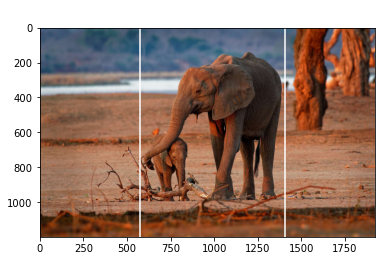

In [107]:
draw_boxes(filename, v_boxes, v_labels, v_scores)

---
## Further predictions

### Zebra

<img src="https://github.com/wikistat/High-Dimensional-Deep-Learning/blob/master/ObjectDetection/img/zebra.jpg?raw=true" width="500"/> 

##### <span style="color:purple">**Todo:** Make the prediction.</span>

In [127]:
# Make the prediction (To be completed)

---
### Savane

<img src="https://github.com/wikistat/High-Dimensional-Deep-Learning/blob/master/ObjectDetection/img/savane.jpg?raw=true" width="500"/> 

##### <span style="color:purple">**Todo:** Make the prediction.</span>

In [128]:
# Make the prediction (To be completed)

---
### Street

<img src="https://github.com/wikistat/High-Dimensional-Deep-Learning/blob/master/ObjectDetection/img/street.jpg?raw=true" width="300"/> 

##### <span style="color:purple">**Todo:** Make the prediction.</span>

In [129]:
# Make the prediction (To be completed)